
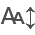

In [1]:
import pandas as pd
from pathlib import Path
import os
from Utils.Utils import check_single_rec_file, get_timestamps_from_rec
from spikeinterface.sorters import read_sorter_folder
from spikeinterface.extractors import read_spikegadgets
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from spikeinterface.extractors import read_phy
import panel as pn
pn.extension('tabulator',design="bootstrap", sizing_mode="fixed",throttled=True)

from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

# Select session

In [20]:

# folder containing .rec file
path_recording_folder = Path(r"/alzheimer/Roberto/Dariya/12/ephys/20240126_184212.rec/")
#path_recording_folder = Path(r"O:\data\12\ephys\20240126_184212.rec")

path_recording, rec_file_name = check_single_rec_file(path_recording_folder)

Exactly one .rec file found: 20240126_184212.rec


## Load Trials

In [21]:
# if needed convert columns names to snake case with: from utils.Utils import camel_to_snake; trials.columns = [camel_to_snake(column) for column in trials.columns]

trials = pd.read_csv(Path(f"{path_recording_folder}/trials.csv"))
print(trials["stimulus_name"].unique())

['BpodProtocols_AuditoryTuning.git'
 'BpodProtocols_DetectionConfidence.git']


In [22]:
trials

trial_n  bpod_start_time  bpod_stop_time  stimulus_block  \
0           0         1.182500        2.382500               0   
1           1         2.494000        3.694000               0   
2           2         3.754300        4.954300               0   
3           3         5.015300        6.215300               0   
4           4         6.272700        7.472700               0   
...       ...              ...             ...             ...   
1299     1299      7240.733867     7246.617667               1   
1300     1300      7252.913467     7258.797267               1   
1301     1301      7265.035067     7270.918867               1   
1302     1302      7277.177267     7283.061067               1   
1303     1303      7289.303567     7295.187367               1   

                              stimulus_name  frequency  volume  \
0          BpodProtocols_AuditoryTuning.git      500.0    60.0   
1          BpodProtocols_AuditoryTuning.git     1000.0    60.0   
2          BpodProtocols_AuditoryTuning.git     1500.0    60.0   
3          BpodProtocols_AuditoryTuning.git     2000.0    60.0   
4          BpodProtocols_AuditoryTuning.git     2500.0    60.0   
...                                     ...        ...     ...   
1299  BpodProtocols_DetectionConfidence.git        NaN     NaN   
1300  BpodProtocols_DetectionConfidence.git        NaN     NaN   
1301  BpodProtocols_DetectionConfidence.git        NaN     NaN   
1302  BpodProtocols_DetectionConfidence.git        NaN     NaN   
1303  BpodProtocols_DetectionConfidence.git        NaN     NaN   

      after_trial_interval  before_trial_interval      beta  ...  \
0                      NaN                    NaN       NaN  ...   
1                      NaN                    NaN       NaN  ...   
2                      NaN                    NaN       NaN  ...   
3                      NaN                    NaN       NaN  ...   
4                      NaN                    NaN       NaN  ...   
...                    ...                    ...       ...  ...   
1299                   1.0                    1.0  0.830212  ...   
1300                   1.0                    1.0 -0.055047  ...   
1301                   1.0                    1.0  0.925595  ...   
1302                   1.0                    1.0 -0.544914  ...   
1303                   1.0                    1.0  0.092597  ...   

      reward_start_time  d_i_o_start_sample  d_i_o_start_time  \
0                   NaN             5263146        175.438200   
1                   NaN             5302492        176.749733   
2                   NaN             5340301        178.010033   
3                   NaN             5378131        179.271033   
4                   NaN             5415854        180.528467   
...                 ...                 ...               ...   
1299                NaN           222451253       7415.041767   
1300                NaN           222816644       7427.221467   
1301                NaN           223180294       7439.343133   
1302                NaN           223544563       7451.485433   
1303                NaN           223908355       7463.611833   

      d_i_o_start_sample_zeroed   start_time  duration    stop_time  has_gap  \
0                             0     0.000000    1.2000     1.200000    False   
1                         39346     1.311533    1.2000     2.511533    False   
2                         77155     2.571833    1.2000     3.771833    False   
3                        114985     3.832833    1.2000     5.032833    False   
4                        152708     5.090300    1.2000     6.290300    False   
...                         ...          ...       ...          ...      ...   
1299                  217188107  7240.591700    5.8838  7246.475500    False   
1300                  217553498  7252.771400    5.8838  7258.655200    False   
1301                  217917148  7264.893067    5.8838  7270.776867    False   
1302                  

## Load spike times and units table

In [23]:
%%time
raw_rec = read_spikegadgets(path_recording)

timestamps = get_timestamps_from_rec(path_recording_folder,  path_recording)

fs = raw_rec.get_sampling_frequency()

times = timestamps/fs
#raw_rec.set_times(times) # set new times, RIGHT NOW IT DOES NOT PROPAGATE TO SORTING OBJECT!


Found 1 timestamps.dat files
Read timestamps from /alzheimer/Roberto/Dariya/12/ephys/20240126_184212.rec/test/20240126_184212.timestamps.dat


/alzheimer/Roberto/Github/spikesorting/Utils/TrodesToPython/readTrodesExtractedDataFile3.py:114: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


CPU times: user 591 ms, sys: 3.1 s, total: 3.69 s
Wall time: 10.9 s


In [24]:
%%time
metrics_list=[]
last_unit_id = 0
spike_times = {}
for n, probe in tqdm(enumerate(os.listdir(f"{path_recording_folder}/spike_interface_output"))):
    #sorting = read_sorter_folder(f"{path_recording_folder}/spike_interface_output/{probe}")
    sorting = read_phy(f"{path_recording_folder}/spike_interface_output/{probe}/sorter_output/")

    #sorting.register_recording(raw_rec)
    for unit_id in tqdm(sorting.unit_ids):
        spike_times[unit_id + last_unit_id] = times[sorting.get_unit_spike_train(unit_id=unit_id)]

    metrics = pd.read_csv(f"{path_recording_folder}/spike_interface_output/{probe}/metrics")
    metrics.set_index("unit_id", inplace=True)

    # Check if the index is strictly increasing
    assert metrics.index.is_monotonic_increasing, "Index is not strictly increasing."

    # Check if the index has unique values
    assert metrics.index.is_unique, "Index has repeating values."
    
    np.testing.assert_array_equal(sorting.unit_ids,  metrics.index)# test ids are updated
    
    metrics.index = metrics.index + last_unit_id
    last_unit_id = metrics.index[-1]
    metrics_list.append(metrics)

0it [00:00, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/alzheimer/Roberto/Dariya/12/ephys/20240126_184212.rec/spike_interface_output/probe1/metrics'

In [25]:

units = pd.concat(metrics_list)

ValueError: No objects to concatenate

In [27]:
units = pd.DataFrame(index=spike_times.keys())

In [28]:
units

""
Loading... (need help?)


In [29]:
%%time
# PSTH in 100 ms bins. 0 means bin 0-0.1 s
# prepare widgets


unit_ids_w = pn.widgets.Tabulator(units, selection=list(units.index[0:2]),sizing_mode='stretch_width',theme="bulma", disabled=True, page_size=10, layout='fit_data_table')
target_w = pn.widgets.Select(value="start_time", options=["start_time", "reward_start_time", "stimulus_start_time"], name='Zeroed on')
filter_trials_w = pn.widgets.Select(name='Filter trials', value=None, options=[None,'broke_fixation',
 'catch_trial',
 'choice_left',
 'cout_early',
 'early_withdrawal',
 'embed_signal',
 'invalid_response_correct',
 'invalid_response_left',
 'laser_stimulation',
 'laser_trial',
 'light_guidance',
 'lout_early',
 'photometry_on',
 'post_trial_recording',
 'repeat_mode',
 'response_correct',
 'response_left',
 'reward_amount_center',
 'reward_amount_error',
 'reward_received_center',
 'reward_received_error',
 'rewarded'])
select_task_w = pn.widgets.Select(name='Select task', value=trials["stimulus_name"].unique()[0], options=list(trials["stimulus_name"].unique()))
window_w = pn.widgets.RangeSlider(
    name='Range Slider', start=-4, end=4, value=(-2, 2), step=0.1)


def makePSTH(spikes, startTimes, windowDur, binSize=0.01):
    bins = np.arange(0, windowDur + binSize, binSize)
    counts = np.zeros(bins.size - 1)
    for i, start in enumerate(startTimes):
        startInd = np.searchsorted(spikes, start)
        endInd = np.searchsorted(spikes, start + windowDur)
        counts = counts + np.histogram(spikes[startInd:endInd] - start, bins)[0]

    counts = counts / startTimes.size
    return counts / binSize, bins

#TODO test this

@pn.depends(select_task_w, unit_ids_w.param.selection, target_w, filter_trials_w, window_w)
def PSTH(select_task=trials["stimulus_name"].unique()[0], unit_ids=[5], target="start_time", filter_trials=None, window=(-2, 2)):
 
    unit_ids = units.index[unit_ids]
        
    sub_trials = trials[trials["stimulus_name"]==select_task]
    if filter_trials is not None:
        sub_trials = sub_trials[sub_trials[filter_trials]==True]
    
    n_trials = sub_trials.shape[0]
    start_times = sub_trials[target].values
    
    aggregated_spikes = []
    windowDur = window[1] - window[0]
    for unit_id in unit_ids:
        spikes = spike_times[unit_id]
        unit_change_response, bins = makePSTH(spikes, start_times, windowDur, binSize=0.1)
        aggregated_spikes.append(unit_change_response)
    
    aggregated_spikes = np.array(aggregated_spikes)
    
    index = np.arange(window[0], window[1], 0.1)
    
    fig, ax = plt.subplots()
    pd.DataFrame(aggregated_spikes, columns=index[:-1]).T.mean(axis=1).plot(ax=ax)
    ax.set_title(f"n trials= {n_trials}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Spike rate per 100 ms")
    plt.close()
    return fig

CPU times: user 21.4 ms, sys: 0 ns, total: 21.4 ms
Wall time: 19.8 ms


In [32]:
trials["stimulus_name"].unique()

array(['BpodProtocols_AuditoryTuning.git',
       'BpodProtocols_DetectionConfidence.git'], dtype=object)

In [34]:
spike_times[0]


array([4.66336667e+00, 5.32693333e+00, 5.48330000e+00, ...,
       7.19992490e+03, 7.20004280e+03, 7.31499233e+03])

In [31]:
trials

trial_n  bpod_start_time  bpod_stop_time  stimulus_block  \
0           0         1.182500        2.382500               0   
1           1         2.494000        3.694000               0   
2           2         3.754300        4.954300               0   
3           3         5.015300        6.215300               0   
4           4         6.272700        7.472700               0   
...       ...              ...             ...             ...   
1299     1299      7240.733867     7246.617667               1   
1300     1300      7252.913467     7258.797267               1   
1301     1301      7265.035067     7270.918867               1   
1302     1302      7277.177267     7283.061067               1   
1303     1303      7289.303567     7295.187367               1   

                              stimulus_name  frequency  volume  \
0          BpodProtocols_AuditoryTuning.git      500.0    60.0   
1          BpodProtocols_AuditoryTuning.git     1000.0    60.0   
2          BpodProtocols_AuditoryTuning.git     1500.0    60.0   
3          BpodProtocols_AuditoryTuning.git     2000.0    60.0   
4          BpodProtocols_AuditoryTuning.git     2500.0    60.0   
...                                     ...        ...     ...   
1299  BpodProtocols_DetectionConfidence.git        NaN     NaN   
1300  BpodProtocols_DetectionConfidence.git        NaN     NaN   
1301  BpodProtocols_DetectionConfidence.git        NaN     NaN   
1302  BpodProtocols_DetectionConfidence.git        NaN     NaN   
1303  BpodProtocols_DetectionConfidence.git        NaN     NaN   

      after_trial_interval  before_trial_interval      beta  ...  \
0                      NaN                    NaN       NaN  ...   
1                      NaN                    NaN       NaN  ...   
2                      NaN                    NaN       NaN  ...   
3                      NaN                    NaN       NaN  ...   
4                      NaN                    NaN       NaN  ...   
...                    ...                    ...       ...  ...   
1299                   1.0                    1.0  0.830212  ...   
1300                   1.0                    1.0 -0.055047  ...   
1301                   1.0                    1.0  0.925595  ...   
1302                   1.0                    1.0 -0.544914  ...   
1303                   1.0                    1.0  0.092597  ...   

      reward_start_time  d_i_o_start_sample  d_i_o_start_time  \
0                   NaN             5263146        175.438200   
1                   NaN             5302492        176.749733   
2                   NaN             5340301        178.010033   
3                   NaN             5378131        179.271033   
4                   NaN             5415854        180.528467   
...                 ...                 ...               ...   
1299                NaN           222451253       7415.041767   
1300                NaN           222816644       7427.221467   
1301                NaN           223180294       7439.343133   
1302                NaN           223544563       7451.485433   
1303                NaN           223908355       7463.611833   

      d_i_o_start_sample_zeroed   start_time  duration    stop_time  has_gap  \
0                             0     0.000000    1.2000     1.200000    False   
1                         39346     1.311533    1.2000     2.511533    False   
2                         77155     2.571833    1.2000     3.771833    False   
3                        114985     3.832833    1.2000     5.032833    False   
4                        152708     5.090300    1.2000     6.290300    False   
...                         ...          ...       ...          ...      ...   
1299                  217188107  7240.591700    5.8838  7246.475500    False   
1300                  217553498  7252.771400    5.8838  7258.655200    False   
1301                  217917148  7264.893067    5.8838  7270.776867    False   
1302                  

Column(design=<class 'panel.theme.bootst...)
    [0] Column(design=<class 'panel.theme.bootst...)
        [0] Markdown(str, design=<class 'panel.theme.bootst...)
        [1] Row(design=<class 'panel.theme.bootst...)
            [0] Select(design=<class 'panel.theme.bootst..., options=['BpodProtocols_AuditoryTu...], value='BpodProtocols_AuditoryTun...)
            [1] Select(design=<class 'panel.theme.bootst..., name='Zeroed on', options=['start_time', ...], value='start_time')
            [2] Select(design=<class 'panel.theme.bootst..., name='Filter trials', options=[None, 'broke_fixation', ...])
        [2] Markdown(str, design=<class 'panel.theme.bootst...)
        [3] Tabulator(design=<class 'panel.theme.bootst..., disabled=True, page_size=10, pagination='local', selection=[0, 1], sizing_mode='stretch_width', theme='bulma', value=Empty DataFrame
Columns: [...)
    [1] Matplotlib(Figure, design=<class 'panel.theme.bootst...)
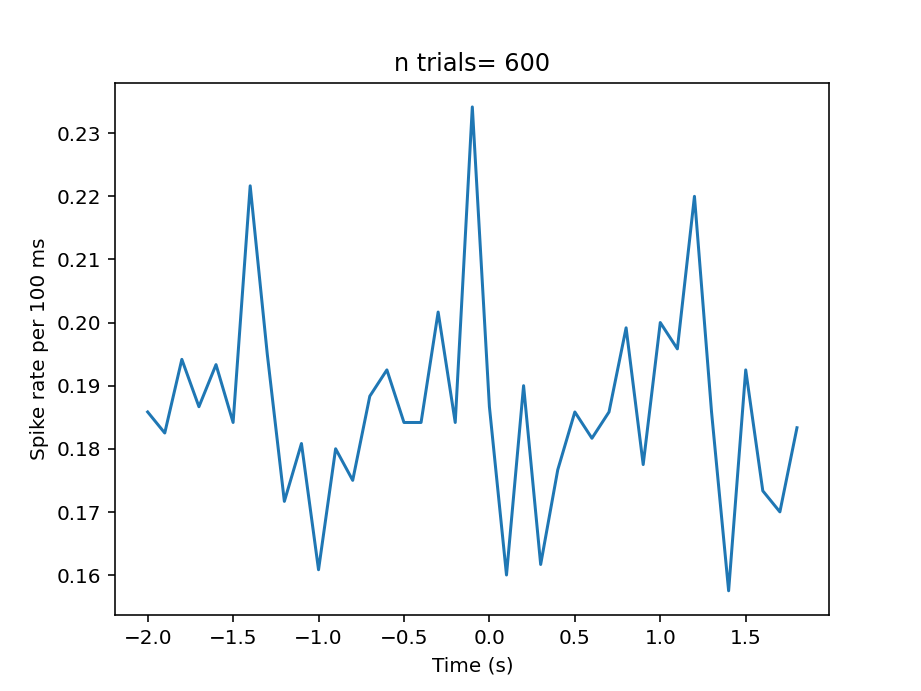

In [30]:
pn.Column(
    pn.Column('## Controls',pn.Row(select_task_w,  target_w, filter_trials_w), pn.pane.Markdown('#### Select units'),unit_ids_w,),
    pn.pane.Matplotlib(PSTH
))

In [94]:
_ = pn.Column(
    pn.Column('## Controls',pn.Row(select_task_w,  target_w, filter_trials_w), pn.pane.Markdown('#### Select units'),unit_ids_w,),
    pn.pane.Matplotlib(PSTH
)).servable()

In [95]:
pn.serve(_)

Launching server at http://localhost:46625
